#### Go to https://pytorch.org/ and follow the instructions to install PyTorch.

## Imports

In [9]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.utils.data as Data
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
from tqdm import tqdm
%matplotlib inline

## Import dataset

In [5]:
# path = Path().cwd()
data_file = "../Data/zipdata.mat"

# data_file = path / "zipdata.mat"
data = scipy.io.loadmat(data_file)

X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long).squeeze()
y_test = torch.tensor(y_test, dtype=torch.long).squeeze()
y_val = torch.tensor(y_val, dtype=torch.long).squeeze()

### setup loaders

In [6]:
BATCH_SIZE = 50

# set up a loader for training and test data
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

val_dataset = Data.TensorDataset(X_val, y_val)
val_loader = Data.DataLoader(
    dataset=val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

test_dataset = Data.TensorDataset(X_test, y_test)
test_loader = Data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

## Artificial Neural Network

In [14]:
# ann with 2 layers
class netWork(torch.nn.Module):
    def __init__(self, n_feature, n_hidden_layers, n_output):
        super(netWork, self).__init__()

        n_hidden_layers.insert(0, n_feature)

        self.layers = []  # hidden layers
        for i in range(len(n_hidden_layers)-1):
            self.layers.append(
                torch.nn.Linear(n_hidden_layers[i], n_hidden_layers[i+1])
            )
                
        self.predict = torch.nn.Linear(n_hidden_layers[-1], n_output)   # output layer

    def forward(self, x):
        
        for layer in self.layers:
            x = F.relu(layer(x))      # activation function for hiddens
        
        x = self.predict(x)             # linear output
        
        return x

num_classes= 10
number_of_features = 256
n_hidden_layers = [25, 50]  #Try modifing this
learning_rate = 0.001
    
model = netWork(n_feature=number_of_features, n_hidden_layers = n_hidden_layers, n_output=num_classes)     # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

## Early stopping

In [13]:
# from https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.bestModel = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics, curmodel):
        if self.best is None:
            self.best = metrics
            self.bestModel = curmodel
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
            self.bestModel = curmodel
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)
                

                
# play around with patience
# The early stopping module takes in the following parameters
# mode='min' / 'max' - whether smaller or lager is better
# min_delta=0 - a delta that can be used to make early stopping more or less lenient when evaulating "bad" epochs
# patience=10 - how many "bad" epochs that are allowed(epoches with worse score than the current best)
# percentage=False / True - whether the criterion is in percentage or not
earlyStopping = EarlyStopping(patience=5)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:22<00:00, 12.09it/s]


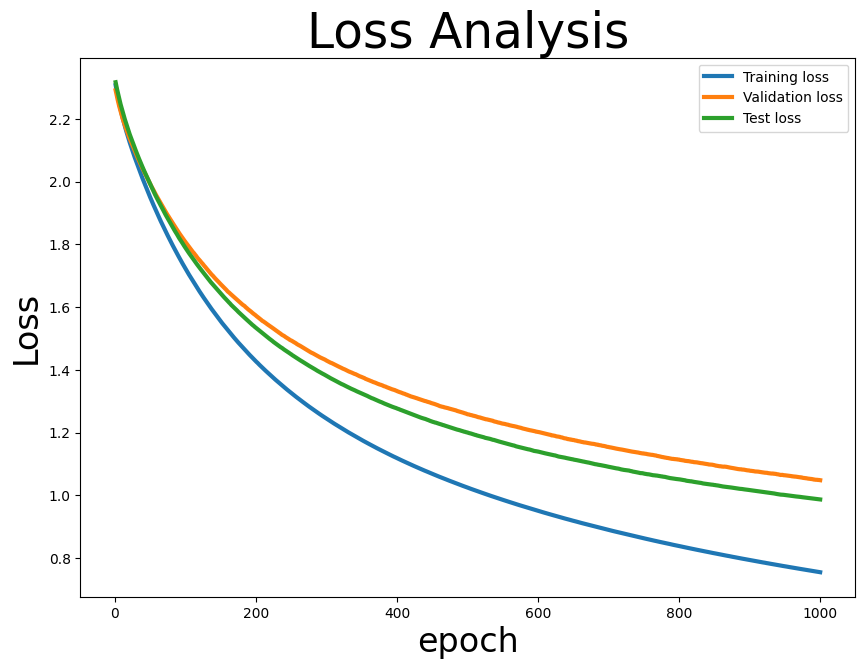

In [15]:
EPOCH = 1000
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
val_loss_graph = []
test_loss_graph = []
for epoch in tqdm(range(EPOCH)):
    train_loss_tot = 0 # Save for plotting
    model.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(train_loader): # for each training step
        
        predictions = model(inputs_)     # input x and predict based on x
        
        loss = loss_func(predictions, targets_)   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    val_loss_tot = 0 # Save for plotting
    model.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(val_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        val_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    for s, (inputs_, targets_) in enumerate(test_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(train_dataset))
    val_loss_graph.append(val_loss_tot/len(val_dataset))
    test_loss_graph.append(test_loss_tot/len(test_dataset))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, val_loss_graph, lw=3, label='Validation loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    
    if earlyStopping.step(torch.tensor(val_loss_tot/len(val_dataset)),model):
        print('Exited due to early stopping')
        model = earlyStopping.bestModel
        break  # early stop criterion is met, we can stop now

### Get the predictions of the best model

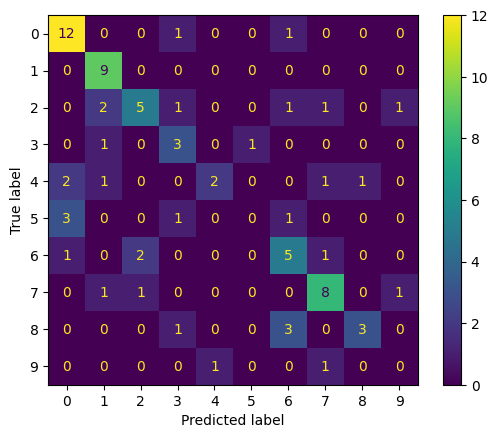

In [11]:
preds_tot = torch.zeros(len(test_dataset),num_classes)
for s, (inputs_, _) in enumerate(test_loader): # for each testing batch
                
    predictions = model(inputs_)     # input x and predict based on x
    
    endIndex = (BATCH_SIZE*(s+1)) if (BATCH_SIZE*(s+1)) <= len(test_dataset) else len(test_dataset)
    preds_tot[(BATCH_SIZE*s):endIndex,:] = predictions.data
    
preds = np.argmax(preds_tot,axis=1)
cm = confusion_matrix(y_test,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# Run this cell to iterate through all predictions
# Track current index (global across runs)
if "index" not in globals():
    index = 0

# Plot setup
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

# Image subplot
ax_img = fig.add_subplot(gs[0, :])
ax_img.axis('off')

# Bar chart subplot
ax_bar = fig.add_subplot(gs[1, :])
ax_bar.set_title('Digit Recognition Probability')
ax_bar.set_ylim([0, 1])
ax_bar.set_xticks(np.arange(10))

# Get data for current step
input_ = X_test[index]
target_ = y_test[index]
predictions_ = preds_tot[index]
probs = F.softmax(predictions_, dim=0).numpy()
pred = np.argmax(probs)

# Plot image
ax_img.imshow(input_.reshape(16, 16), cmap='gray', interpolation='nearest')
ax_img.set_title(f"[{index}] Predicted: {pred}, Actual: {target_.item()}")

# Plot bar chart
ax_bar.bar(np.arange(10), probs, color='skyblue')

plt.show()

# Move to next sample for the next cell run
index = (index + 1) % len(X_test)

## Weight Decay

In [ ]:
weight_decay = 0.1 #Try modifing this
n_hidden_layers = [25, 50] #Try modifing this
learning_rate = 0.001

model = netWork(n_feature=number_of_features, n_hidden_layers = n_hidden_layers, n_output=num_classes)     # define the network
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
EPOCH = 500
fig, ax = plt.subplots(figsize=(10,7))

# train the network
train_loss_graph = []
val_loss_graph = []
test_loss_graph = []
for epoch in range(EPOCH):
    train_loss_tot = 0 # Save for plotting
    model.train() # prepare model for training
    for s, (inputs_, targets_) in enumerate(train_loader): # for each training step
        
        predictions = model(inputs_)     # input x and predict based on x
        
        loss = loss_func(predictions, targets_)   # compute the loss. must be (1. nn output, 2. target)
        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients 

        #save the loss for plotting
        train_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    val_loss_tot = 0 # Save for plotting
    model.eval() # prepare model for testing
    for s, (inputs_, targets_) in enumerate(val_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        val_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
    
    test_loss_tot = 0 # Save for plotting
    for s, (inputs_, targets_) in enumerate(test_loader): # for each testing batch
                
        predictions = model(inputs_)     # input x and predict based on x
    
        loss = loss_func(predictions, targets_)  # compute the loss. must be (1. nn output, 2. target)

        #save the loss for plotting
        test_loss_tot += loss.item() * inputs_.shape[0] #Multiply with the current batchsize to get pr. sample loss
        
    train_loss_graph.append(train_loss_tot/len(train_dataset))
    val_loss_graph.append(val_loss_tot/len(val_dataset))
    test_loss_graph.append(test_loss_tot/len(test_dataset))

    plt.cla()
    # plot and show learning process
    ax.set_title('Loss Analysis', fontsize=35)
    ax.set_xlabel('epoch', fontsize=24)
    ax.set_ylabel('Loss', fontsize=24)
    x = np.arange(1,epoch+2)
    
    ax.plot(x, train_loss_graph, lw=3, label='Training loss')
    ax.plot(x, val_loss_graph, lw=3, label='Validation loss')
    ax.plot(x, test_loss_graph, lw=3, label='Test loss')
    ax.legend()
    fig.canvas.draw()       # draw the canvas, cache the renderer

In [ ]:
preds_tot = torch.zeros(len(test_dataset),num_classes)
for s, (inputs_, _) in enumerate(test_loader): # for each testing batch
                
    predictions = model(inputs_)     # input x and predict based on x
    
    endIndex = (BATCH_SIZE*(s+1)) if (BATCH_SIZE*(s+1)) <= len(test_dataset) else len(test_dataset)
    preds_tot[(BATCH_SIZE*s):endIndex,:] = predictions.data
    
preds = np.argmax(preds_tot,axis=1)
cm = confusion_matrix(y_test,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# Track current index (preserved across runs)
if 'index' not in globals():
    index = 0

# Create figure and layout
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

# Image display (digit)
ax = plt.Subplot(fig, gs[0])
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
fig.add_subplot(ax)

# Prediction bar chart
axBar = fig.add_subplot(gs[1, :])
probs = F.softmax(preds_tot[index], dim=0).numpy()
bars = axBar.bar(np.arange(10), probs)
axBar.set_title('Digit Recognition Probability')
axBar.set_ylim([0, 1])
axBar.set_xticks(np.arange(10))

# Data for current index
input_ = X_test[index]
target_ = y_test[index]
predictions_ = preds_tot[index]
pred = torch.argmax(predictions_).item()

# Update image
vmax = max(input_.max(), -input_.min())
ax.set_title(f'[{index}] Predicted {pred}, Actual {target_.item()}')
ax.imshow(input_.reshape((16, 16)), cmap=plt.cm.gray,
          interpolation='nearest', vmin=-vmax, vmax=vmax)

# Update bar heights
for bar, h in zip(bars, probs):
    bar.set_height(h)

plt.show()

# Advance index for next run
index = (index + 1) % len(X_test)